# Impact of travel time and distance on whether commuters drive alone.



In [291]:
%config Completer.use_jedi = False # autocomplete

import geopandas as gpd
import numpy as np
import pandas as pd
from scipy.stats import pearsonr # For exploring correlations
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns


GEOID = 'GEOID' # blockgroup
SURVEY18_FILEPATH =  '../data/private/transportation_survey/2018TR.csv'
SURVEY18_CODEBOOK_FILEPATH = '../data/private/transportation_survey/2018TR_Codebook.xlsx'

## Distance metrics

Compute distance in multiple ways

- Line distance from MIT
- Commute time via public transit
    
For each metric, we expect that its decrease will correspond with fewer drivers

In [265]:
DISTANCE_TO_MIT = 'distance to MIT (miles)'
DRIVING_DISTANCE = 'driving distance (miles)'
PUBLIC_TRANSIT_TIME = 'public transit time (minutes)'
GEOMETRY = 'geometry'

distance_metrics = [
    DISTANCE_TO_MIT,
    DRIVING_DISTANCE, 
    PUBLIC_TRANSIT_TIME,
]

## Load in the data

Load in the survey data and merge the survey data with geographic information from public sources
Geographic information is from the U.S. Census and Open Streem Map (OSM).

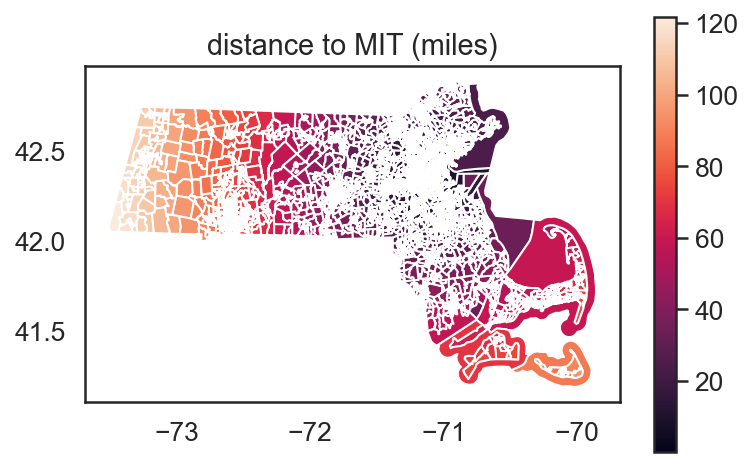

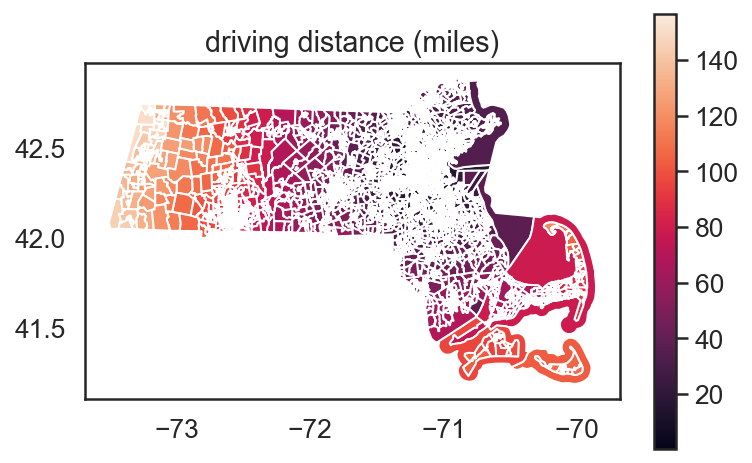

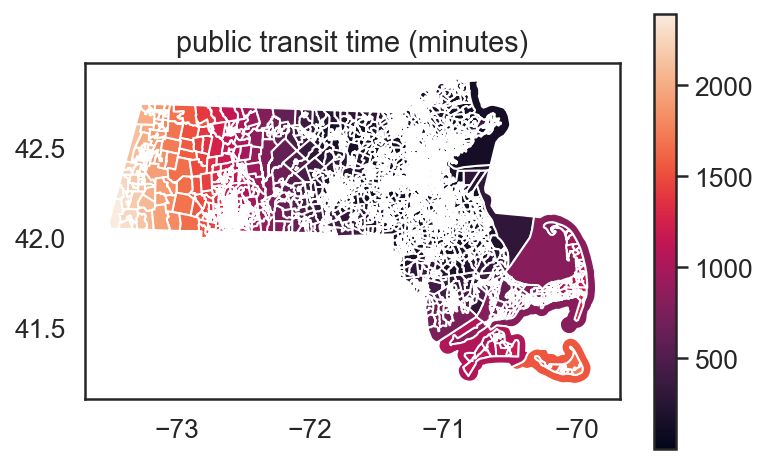

,distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry
GEOID,,,,
250277304011,35.421511,40.303552,152.106474,"POLYGON ((-71.78563 42.30372, -71.78547 42.303..."
250277304014,35.034617,39.689265,152.707570,"POLYGON ((-71.77701 42.30069, -71.77698 42.300..."
250214223022,14.223253,18.698918,73.324261,"POLYGON ((-70.94656 42.18471, -70.94641 42.184..."


In [266]:
bg=gpd.read_file(
    '../data/public/shapes_25_bg/shapes_25_transit_times.shp'
).set_index(GEOID).drop(['COUNTYFP', 'TRACTCE'], axis=1)
bg.columns = [
    DISTANCE_TO_MIT, DRIVING_DISTANCE, PUBLIC_TRANSIT_TIME, GEOMETRY
]
for dist_m in distance_metrics:
    bg.plot(column=dist_m, legend=True)
    plt.title(dist_m)
    plt.show()
bg.head(3)

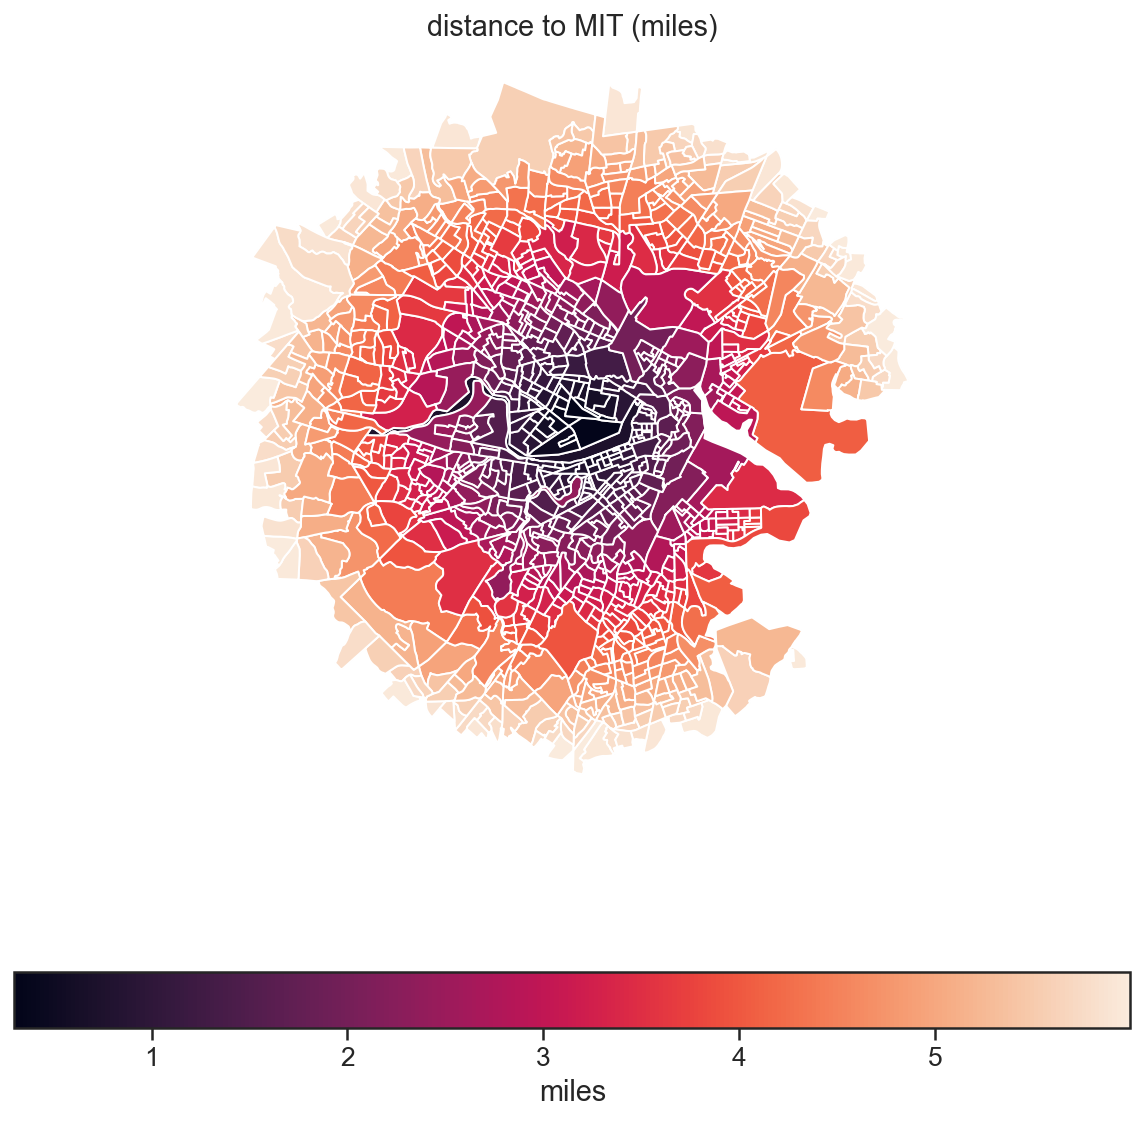

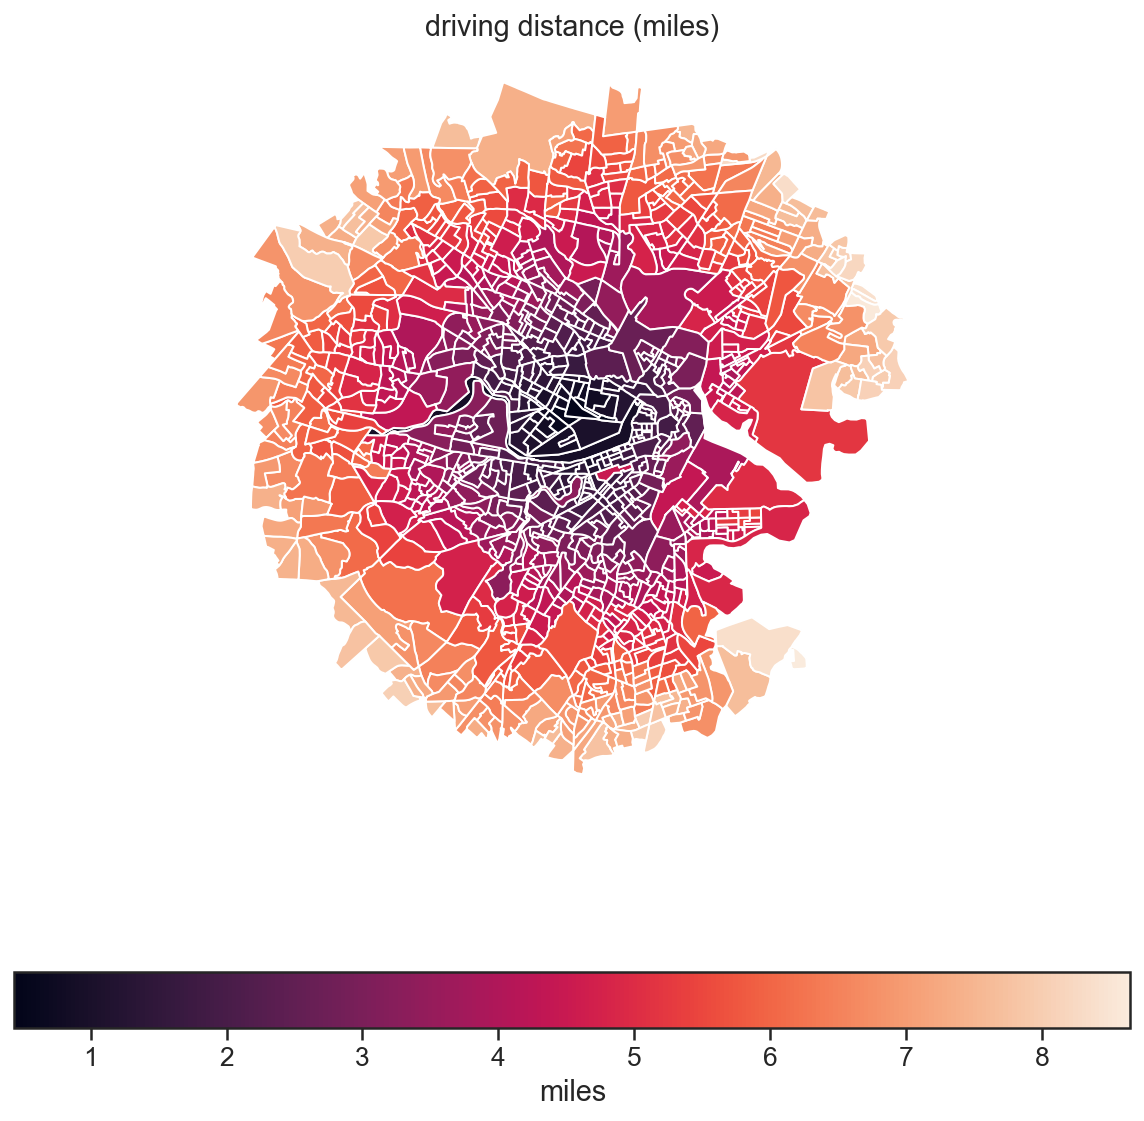

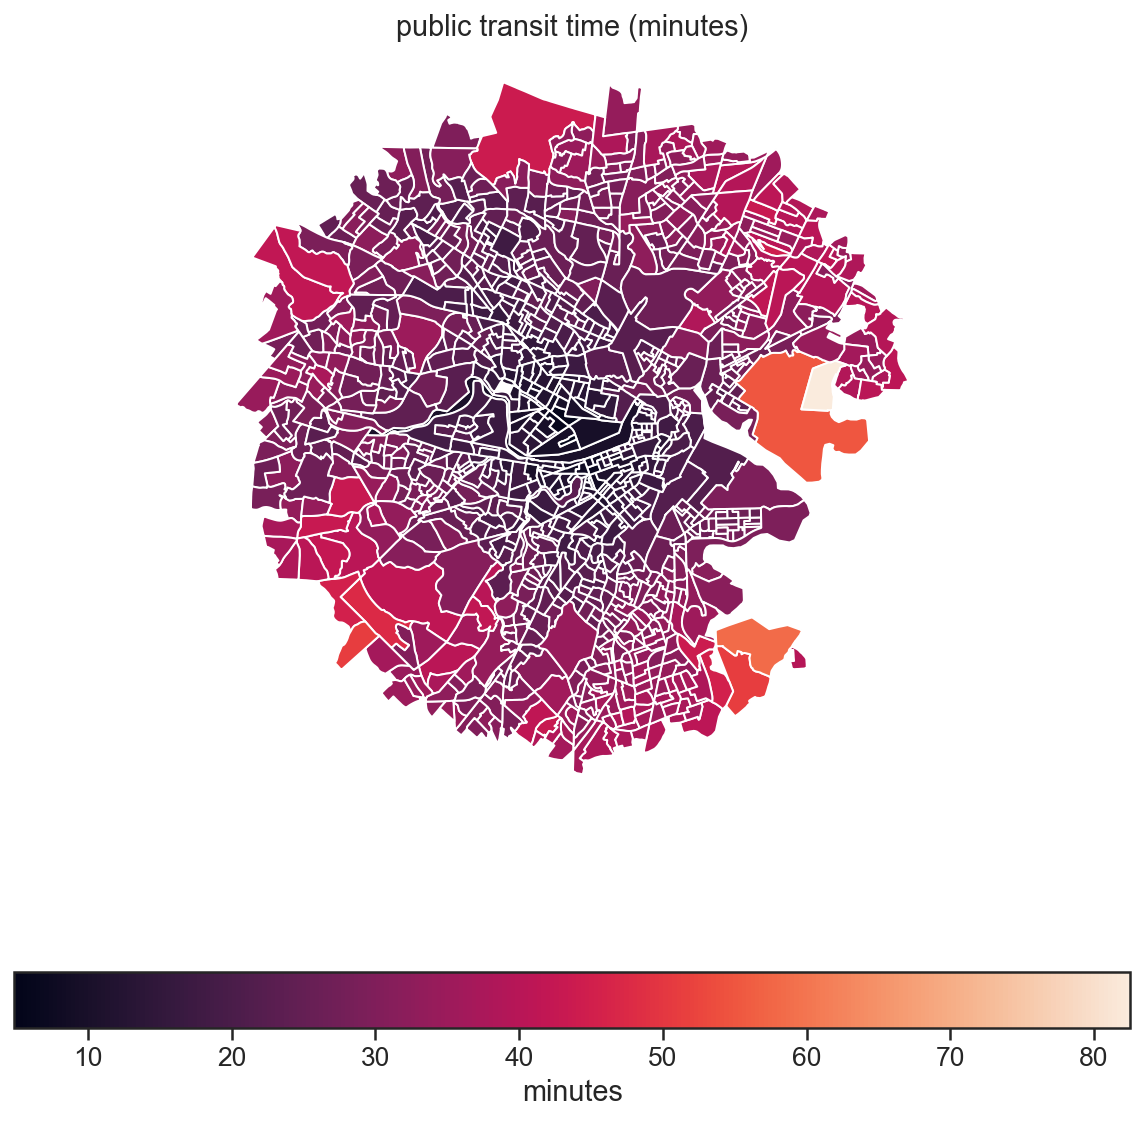

In [438]:
# A close up

for dist_m in [DISTANCE_TO_MIT, DRIVING_DISTANCE]:
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    bg[bg[DISTANCE_TO_MIT]<=6].plot(column=dist_m,
            ax=ax,
            legend=True, 
            legend_kwds={
                'label':'miles',
                'orientation':'horizontal',
            })
    plt.title(dist_m)
    plt.axis('off')
    plt.show()
    
fig, ax = plt.subplots(figsize=(10,10))
bg[
    (bg[PUBLIC_TRANSIT_TIME]<=90) & (bg[DISTANCE_TO_MIT]<=6)
].plot(column=PUBLIC_TRANSIT_TIME,
        ax=ax,
        legend=True, 
        legend_kwds={
            'label':'minutes',
            'orientation':'horizontal',
        })
plt.title(PUBLIC_TRANSIT_TIME)
plt.axis('off')
plt.show()  

## Load in the codebooks that describe the transportation survey data

In [272]:
survey18_codebook = pd.read_excel(SURVEY18_CODEBOOK_FILEPATH, header=1).set_index('Variable')
print('2018 codebook', survey18_codebook.shape)
survey18_codebook[['Label','Measurement Level']].head()

2018 codebook (855, 8)


,Label,Measurement Level
Variable,,
Year,Year survey administered,Scale
ExternalDataReference,ExternalDataReference,Nominal
PID,Unique ID (same for 2016 and 2018),Nominal
ANSWER,Answered Survey,Nominal
TYPE_NUM,Type,Nominal


## Load in the survey data

Andd merge with the geographic and distance data.

In [273]:
def load_data(survey_filepath, bg):
    df = pd.read_csv(survey_filepath,
                         dtype={GEOID: 'str'}, # for easier merging  with shapefile
                          na_values=' ')
    return df.merge(bg, on=GEOID) # People outside of MA are dropped.

survey18_df = load_data(SURVEY18_FILEPATH, bg)
assert(survey18_df['Year'].unique() == [2018])

/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (10,41,72,73,74,75,76,79,80,81,86,92,93,94,95,96,98,99,100,101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Limit the survey data to people who answered the following question about their commuting behavior:

Q95_16: What are your CURRENT commuting method(s) to MIT? (primary)

People were also asked "Please indicate how you commuted TO CAMPUS each day LAST WEEK."

'week_1', ...'week_7' are in in response to that question 

Weight people's likelihood to drive alone with the nuanced daily answers when it is available.

In [274]:
week_day_resp = [
    'week_1', # Monday
    'week_2',
    'week_3',
    'week_4',
    'week_5',
    'week_6', # Saturday
    'week_7', # Sunday
]
completions_df = survey18_df.loc[survey18_df[
    survey18_df['Q95_16'].notnull() | \
     survey18_df[week_day_resp].notnull().any(axis=1)
].index]
completions_n = len(completions_df)
print('%s / %s completion criteria met'%(completions_n, len(survey18_df)))
print('response rate = %.02f'%((completions_n/len(survey18_df))))
completions_df[['Q95_16']+week_day_resp].head(3)

9763 / 20077 completion criteria met
response rate = 0.49


,Q95_16,week_1,week_2,week_3,week_4,week_5,week_6,week_7
0,Drive alone the entire way,Drove alone the entire way,Drove alone the entire way,Drove alone the entire way,Drove alone the entire way,NaN,NaN,NaN
1,"Walk, then take public transportation",Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation",Worked at home or other remote location,Worked at home or other remote location,"Out of office (e.g., sick, vacation, jury duty...","Out of office (e.g., sick, vacation, jury duty..."
3,"Walk, then take public transportation",Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation","Scheduled day off (e.g., weekend)","Scheduled day off (e.g., weekend)"


In [276]:
print(
    '%s possible responses to the question about primary commute method:'\
    % survey18_df['week_1'].nunique())
print(survey18_df['week_1'].unique())

15 possible responses to the question about primary commute method:
['Drove alone the entire way' 'Worked at home or other remote location'
 nan 'Rode in a private car with 1-4 commuters'
 'Walked, then took public transportation'
 'Out of office (e.g., sick, vacation, jury duty, business trip)'
 'Drove alone, then took public transportation' 'Walked'
 'Dropped off at work' 'Bicycled'
 'Shared ride/dropped off, then took public transportation' 'Other'
 'Bicycled and took public transportation'
 'Took a taxi or ride service (e.g., Uber, Lyft)'
 'Scheduled day off (e.g., weekend)'
 'Rode in a vanpool (5+ commuters) or private shuttle (e.g. TechShuttle, SafeRide)']


Compute portion of days people drive alone per week.

In [277]:
DRIVE_ALONE_WEIGHTED = 'drive alone (weighted by days per week)'
MOSTLY_DRIVES = 'Mostly drives alone'

NO_COMMUTE = [
    'Out of office (e.g., sick, vacation, jury duty, business trip)',
    'Scheduled day off (e.g., weekend)',
    'Worked at home',
    'Worked at home or other remote location',
    np.nan,
]

def get_drives_alone_weighted(row, days):
    resp_days = [row[d] for d in days if row[d] not in NO_COMMUTE]
    if len(resp_days):
        return sum((resp == 'Drove alone the entire way') for resp in resp_days)/len(resp_days)
    elif pd.isnull(row['Q95_16']):
        return np.nan
    return 1 if row['Q95_16']=='Drive alone the entire way' else 0

In [278]:
completions_df[DRIVE_ALONE_WEIGHTED] = \
    completions_df.apply(get_drives_alone_weighted, 
                         axis=1,args=([week_day_resp]))

completions_df[MOSTLY_DRIVES] = \
    (completions_df[DRIVE_ALONE_WEIGHTED] >= 0.5)

completions_df[['TYPE_NUM']+week_day_resp+[DRIVE_ALONE_WEIGHTED, MOSTLY_DRIVES]].head(3)

,TYPE_NUM,week_1,week_2,week_3,week_4,week_5,week_6,week_7,drive alone (weighted by days per week),Mostly drives alone
0,Support Staff,Drove alone the entire way,Drove alone the entire way,Drove alone the entire way,Drove alone the entire way,NaN,NaN,NaN,1.0,True
1,Administrative Staff,Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation",Worked at home or other remote location,Worked at home or other remote location,"Out of office (e.g., sick, vacation, jury duty...","Out of office (e.g., sick, vacation, jury duty...",0.0,False
3,Sponsored Research Staff,Worked at home or other remote location,"Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation","Walked, then took public transportation","Scheduled day off (e.g., weekend)","Scheduled day off (e.g., weekend)",0.0,False


What is the distribution for driving alone?

In [279]:
completions_df.groupby('TYPE_NUM')[DRIVE_ALONE_WEIGHTED].describe().sort_values('count')

,count,mean,std,min,25%,50%,75%,max
TYPE_NUM,,,,,,,,
Service Staff,123.0,0.570228,0.470734,0.0,0.0,1.0,1.0,1.0
Faculty,475.0,0.323825,0.428787,0.0,0.0,0.0,1.0,1.0
Sponsored Research Staff,885.0,0.192443,0.363475,0.0,0.0,0.0,0.2,1.0
Support Staff,973.0,0.205479,0.381982,0.0,0.0,0.0,0.2,1.0
Other Academic Group,991.0,0.155581,0.335452,0.0,0.0,0.0,0.0,1.0
Undergraduate Student,1672.0,0.007694,0.077388,0.0,0.0,0.0,0.0,1.0
Administrative Staff,2051.0,0.339029,0.447368,0.0,0.0,0.0,1.0,1.0
Graduate Student,2590.0,0.018038,0.119975,0.0,0.0,0.0,0.0,1.0


In [228]:
types = list(completions_df.groupby('TYPE_NUM').count().sort_values('PID').index)
print(types)

['Service Staff', 'Faculty', 'Sponsored Research Staff', 'Support Staff', 'Other Academic Group', 'Undergraduate Student', 'Administrative Staff', 'Graduate Student']


Text(0.5, 1.0, 'Driving alone weighted by days per week')

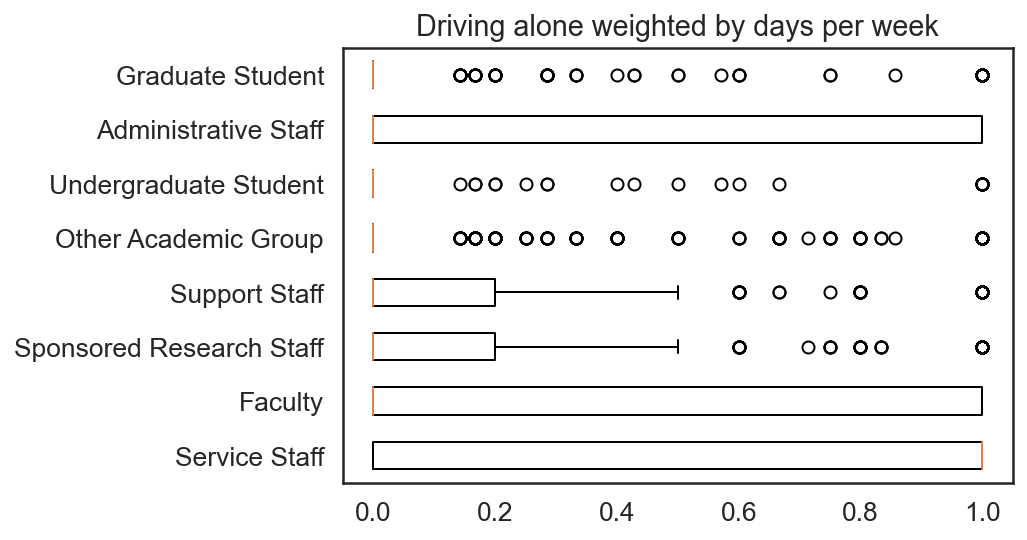

In [229]:
# show by type

fig, ax = plt.subplots()
data = []
for t in types:
    data += [completions_df[
        completions_df['TYPE_NUM']==t
    ][DRIVE_ALONE_WEIGHTED]]
boxes = ax.boxplot(data, vert=False, labels=types)
ax.set_title('Driving alone weighted by days per week')

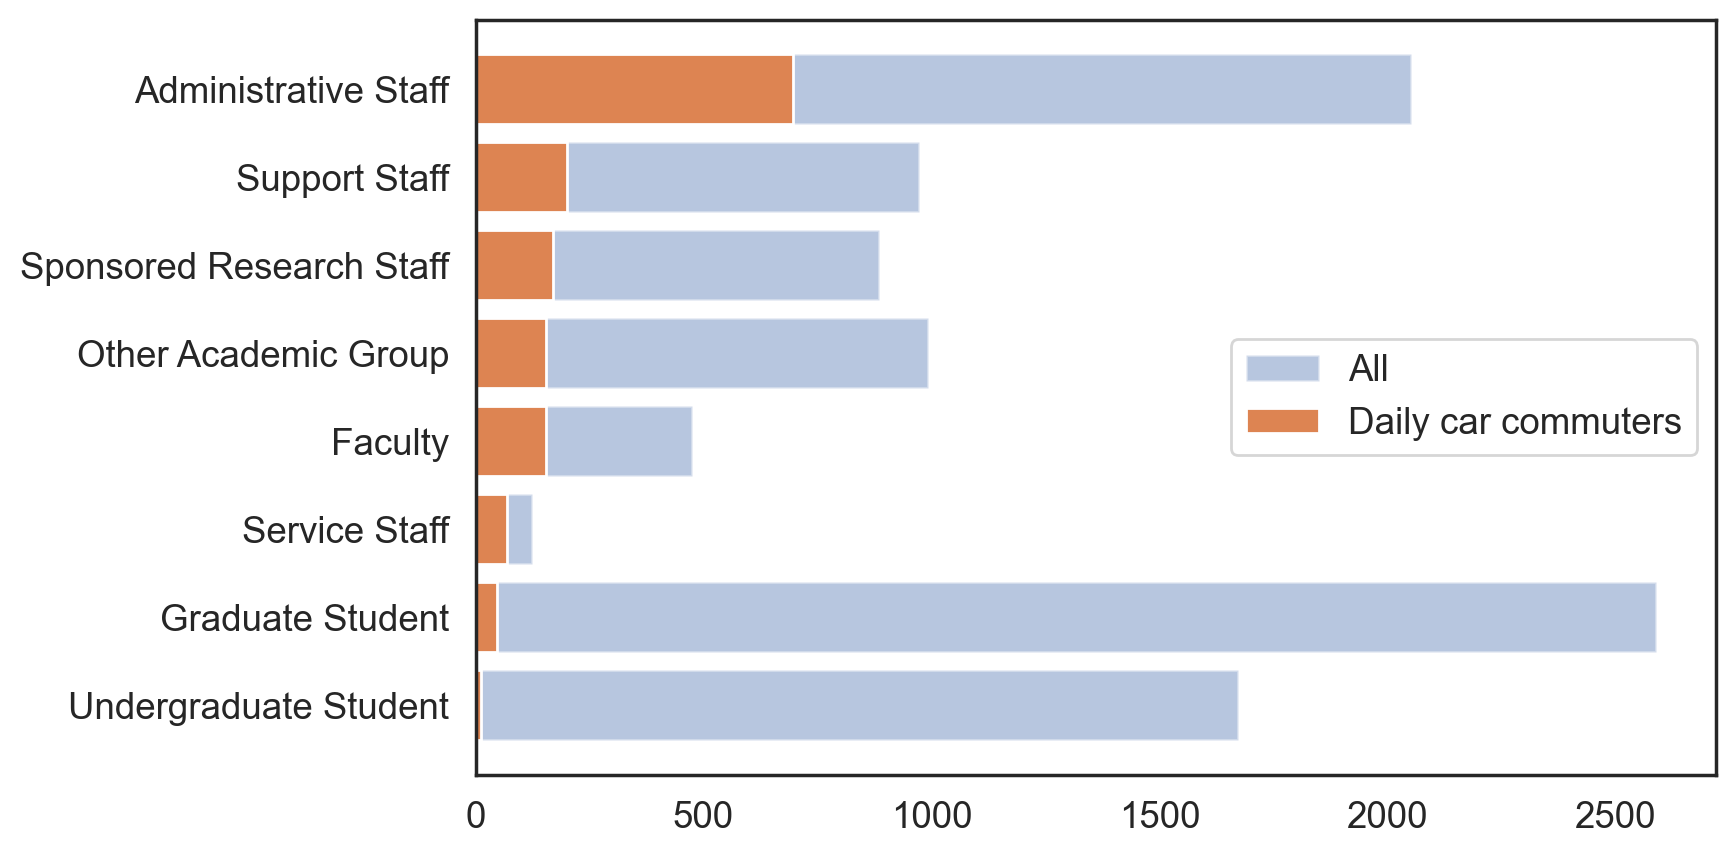

,drive alone (weighted by days per week),N
TYPE_NUM,,
Undergraduate Student,12.864286,1673
Graduate Student,46.719048,2590
Service Staff,70.138095,123
Faculty,153.816667,475
Other Academic Group,154.180952,992
Sponsored Research Staff,170.311905,886
Support Staff,199.930952,973
Administrative Staff,695.347619,2051


In [230]:
agg_drives_alone_by_type_df = \
    completions_df.groupby('TYPE_NUM')[[DRIVE_ALONE_WEIGHTED]].sum()
agg_drives_alone_by_type_df['N'] = \
    completions_df.groupby('TYPE_NUM')[['PID']].count()
agg_drives_alone_by_type_df.sort_values(DRIVE_ALONE_WEIGHTED, inplace=True)

fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)
ax.barh(
    agg_drives_alone_by_type_df.index,
    agg_drives_alone_by_type_df['N'],
    alpha=0.4,
    label='All'
)
ax.barh(
    agg_drives_alone_by_type_df.index,
    agg_drives_alone_by_type_df[DRIVE_ALONE_WEIGHTED],
    label='Daily car commuters'
)
ax.legend()
plt.show()
agg_drives_alone_by_type_df

# Commute distance


What is the distribution of commute distances for the different groups?

In [448]:
plt_df = completions_df[[TYPE_NUM, DISTANCE_TO_MIT, MOSTLY_DRIVES]].copy()
plt_df['Primary commute method'] = plt_df[MOSTLY_DRIVES].map(
    {True: 'Drives alone', False: 'All other modes'}
)
plt_df.head(2)

,TYPE_NUM,distance to MIT (miles),Mostly drives alone,Primary commute method
0,Support Staff,4.987506,True,Drives alone
1,Administrative Staff,4.987506,False,All other modes


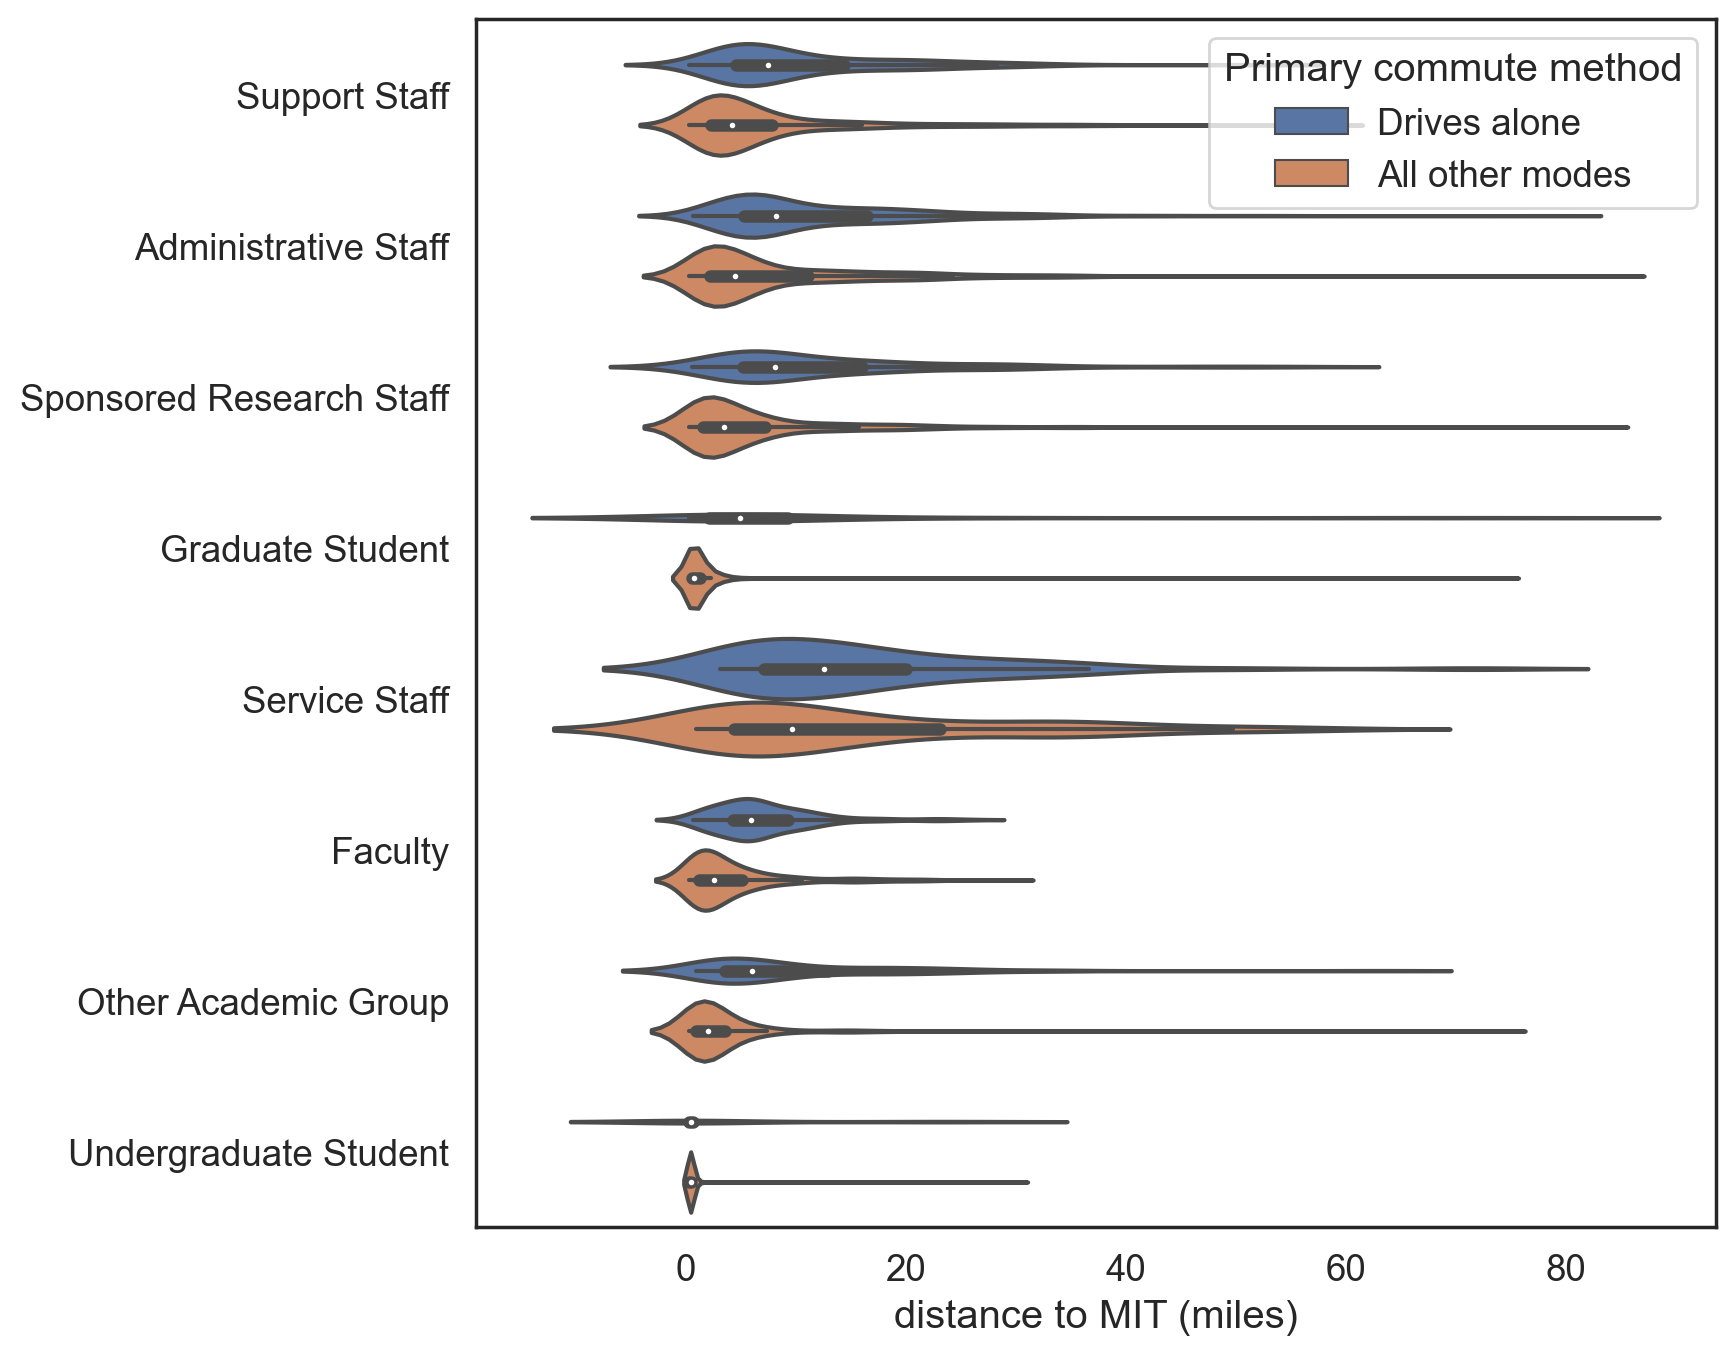

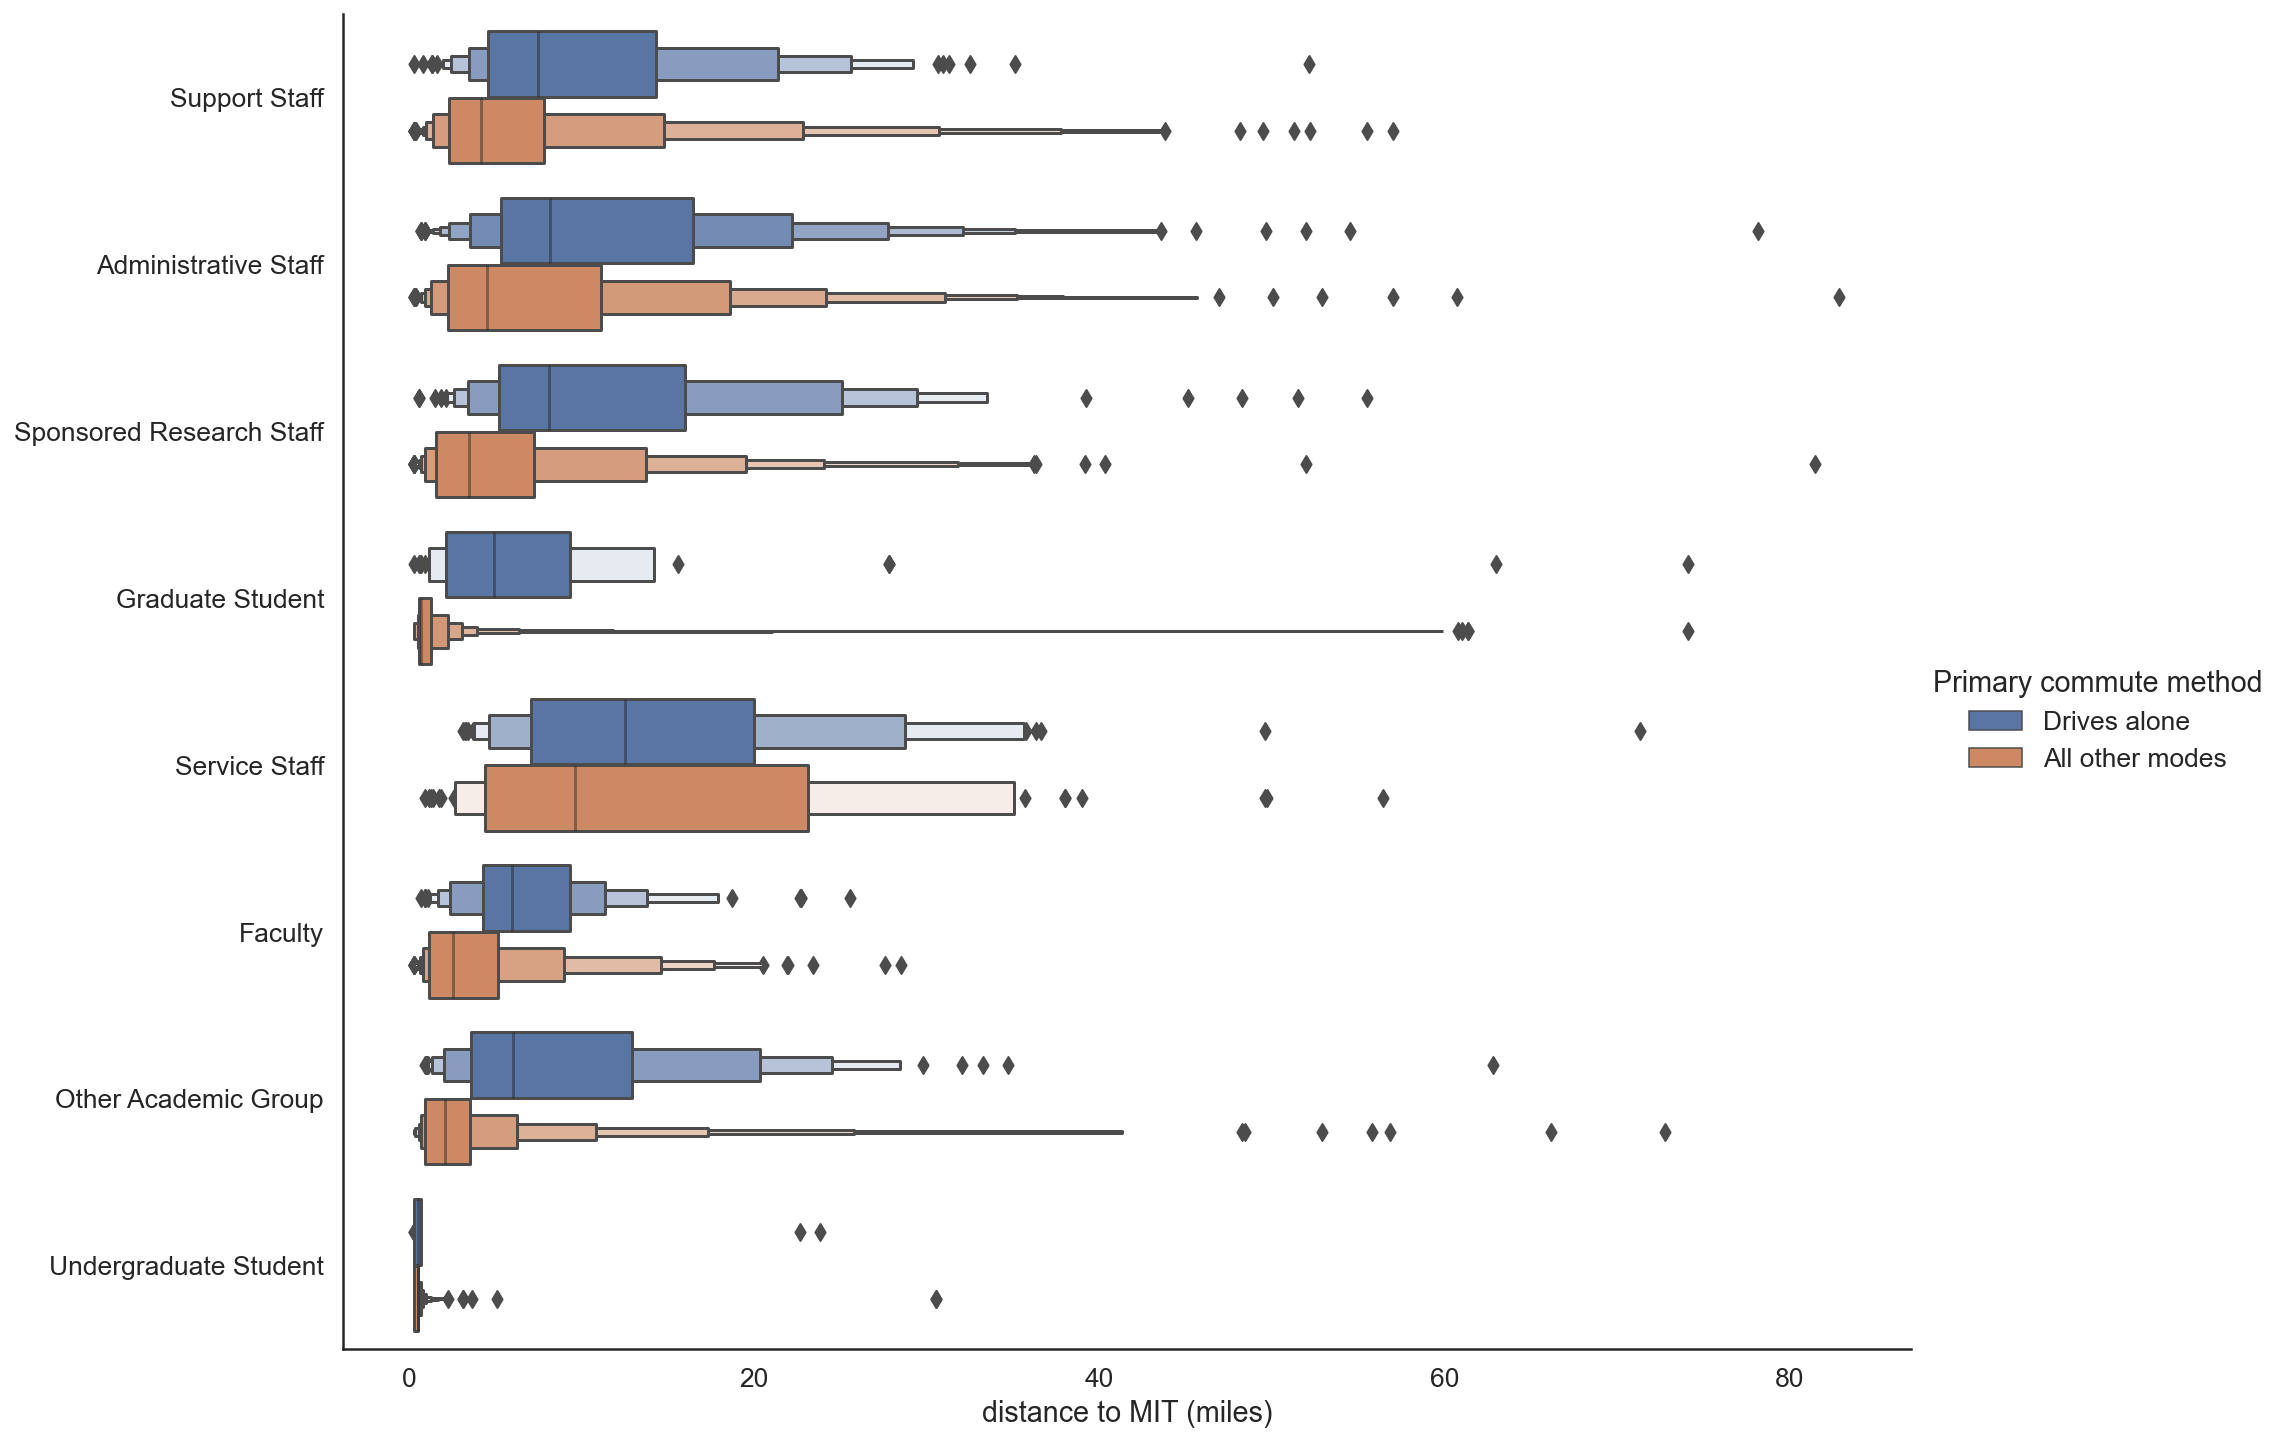

In [452]:
sns.set(font_scale=1.2)
sns.set_style("white")

fig, ax = plt.subplots(1, figsize=(8,8), dpi=100)
_ = sns.violinplot(x=DISTANCE_TO_MIT, y=TYPE_NUM,
                   hue='Primary commute method', data=plt_df, 
                   kind="boxen", ax=ax)
ax.set_ylabel('')
plt.show()
ax=sns.catplot(x=DISTANCE_TO_MIT, y=TYPE_NUM,
               hue='Primary commute method',
               data=plt_df, kind="boxen", height=10, aspect=1.4)
_ = ax.set_ylabels('')
plt.show()

## Correlations between distance and portion of people driving alone by residential census block.

In [236]:
N = 'N'
PID = 'PID'
TYPE_NUM = 'TYPE_NUM'
BENEFITS_ELIGIBLE = 'BenefitsEligible'
DRIVE_ALONE_NORMALIZED = 'Portion driving alone'

In [340]:
def get_geoid_agg_df(df, group=None):
    group = [GEOID] + ([] if group is None else group)
    agg_df = pd.DataFrame({
        N: df.groupby(
            group
        )[PID].count(),
        DRIVE_ALONE_WEIGHTED: df.groupby(
            group
        )[DRIVE_ALONE_WEIGHTED].sum(),
    }).reset_index().set_index(GEOID).merge(bg, on=GEOID)
    agg_df[DRIVE_ALONE_NORMALIZED] = agg_df[DRIVE_ALONE_WEIGHTED]/agg_df[N]
    return agg_df.sort_values(N, ascending=False)

Show correlation for each GEOID, not separated by group.



----------------
 distance to MIT (miles)


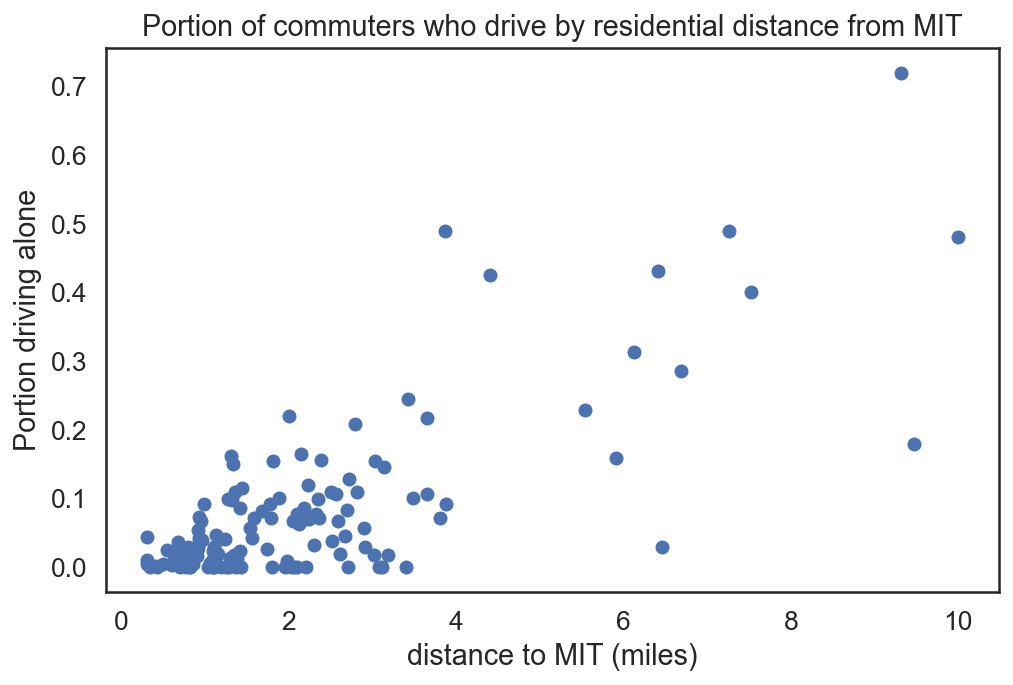

correlation coefficient r = 0.767; p = 0.0


----------------
 driving distance (miles)


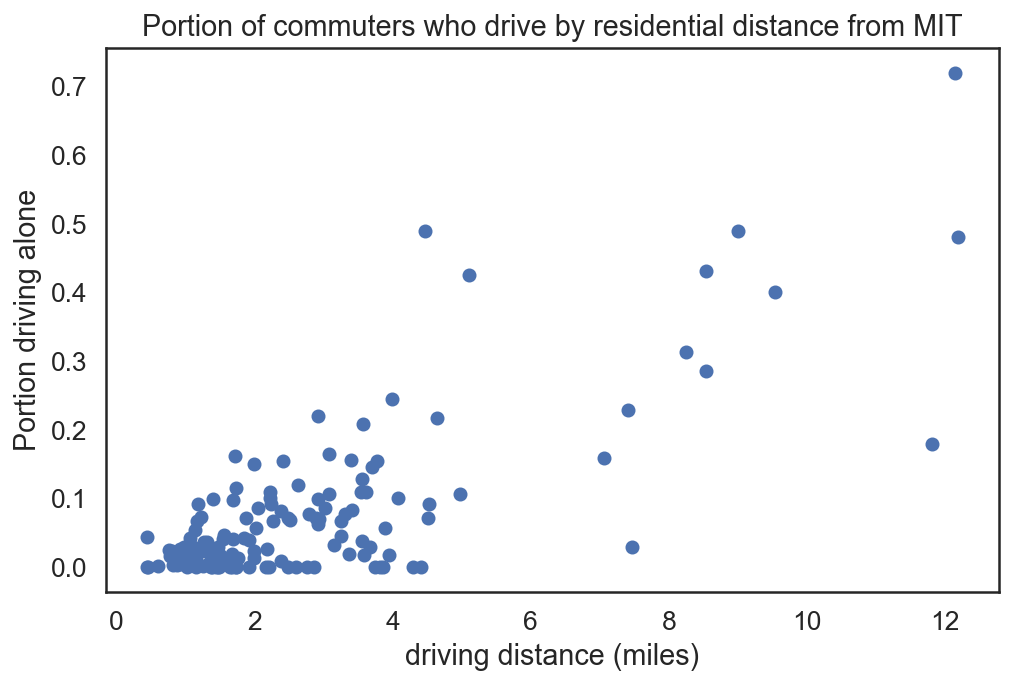

correlation coefficient r = 0.767; p = 0.0


----------------
 public transit time (minutes)


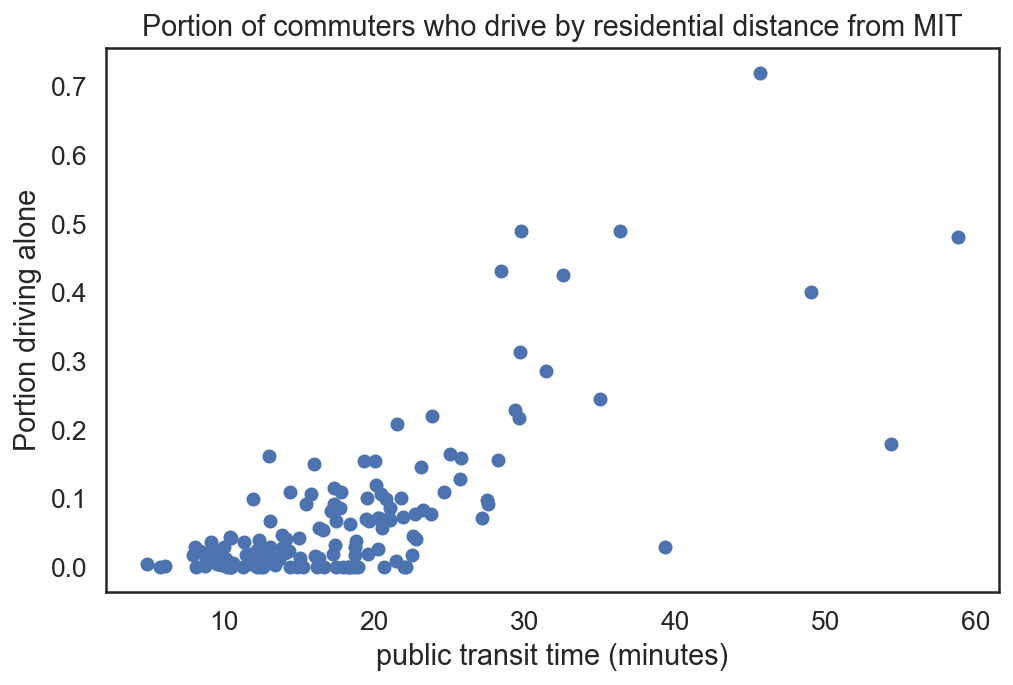

correlation coefficient r = 0.742; p = 0.0


,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,
250173531021,788,3.761905,0.499173,0.923854,9.579971,"POLYGON ((-71.10971 42.35307, -71.10923 42.353...",0.004774
250173531023,594,2.285714,0.304077,1.183525,4.878518,"POLYGON ((-71.09915 42.35594, -71.09802 42.356...",0.003848
250173532001,564,1.652381,0.602097,0.825491,9.831157,"POLYGON ((-71.10721 42.36048, -71.10709 42.360...",0.002930


In [392]:
all_agg_df = get_geoid_agg_df(completions_df)
all_agg_df10 = all_agg_df[all_agg_df[N]>=10]

for dist_m in distance_metrics:
    print('\n\n----------------\n', dist_m)
    x, Y = all_agg_df10[dist_m], all_agg_df10[DRIVE_ALONE_NORMALIZED]
    fig, ax = plt.subplots(1, figsize=(8,5))
    ax.scatter(x, Y)
    title = 'Portion of commuters who drive by residential distance from MIT'
    ax.set_title(title)
    ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
    ax.set_xlabel(dist_m)
    plt.show()
    stat, p = pearsonr(x,Y)
    print('correlation coefficient r = %s; p = %s'%\
          (round(stat, 3), round(p, 3)))

all_agg_df10.head(3)



----------------
 distance to MIT (miles)


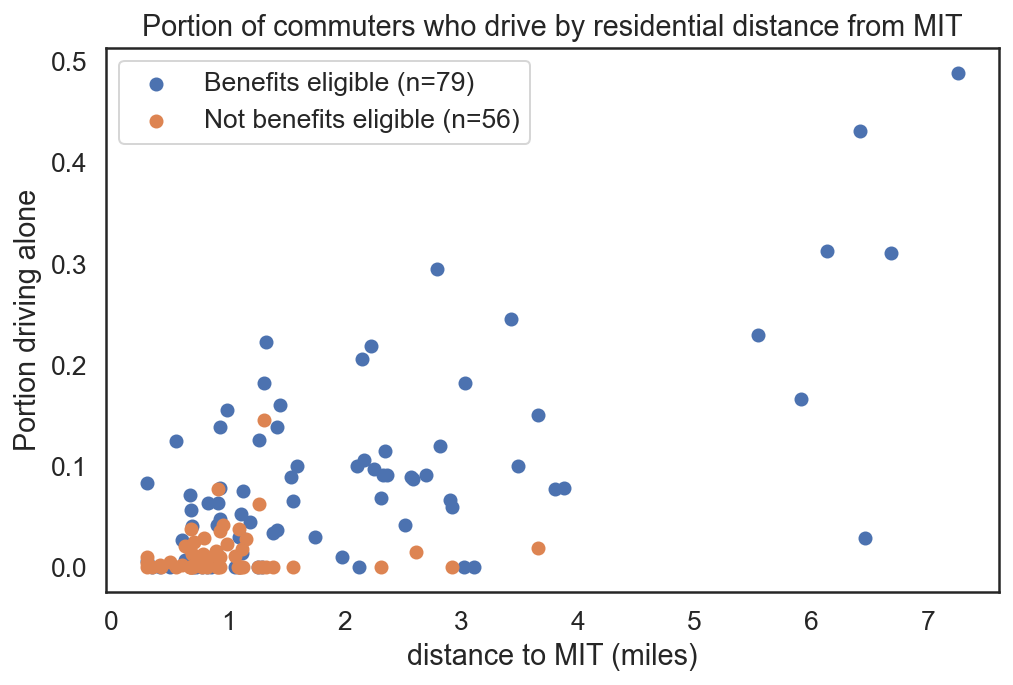

Benefits eligible correlation coefficient r = 0.671; p = 0.0
Non benefits eligible correlation coefficient r = 0.083; p = 0.544


----------------
 driving distance (miles)


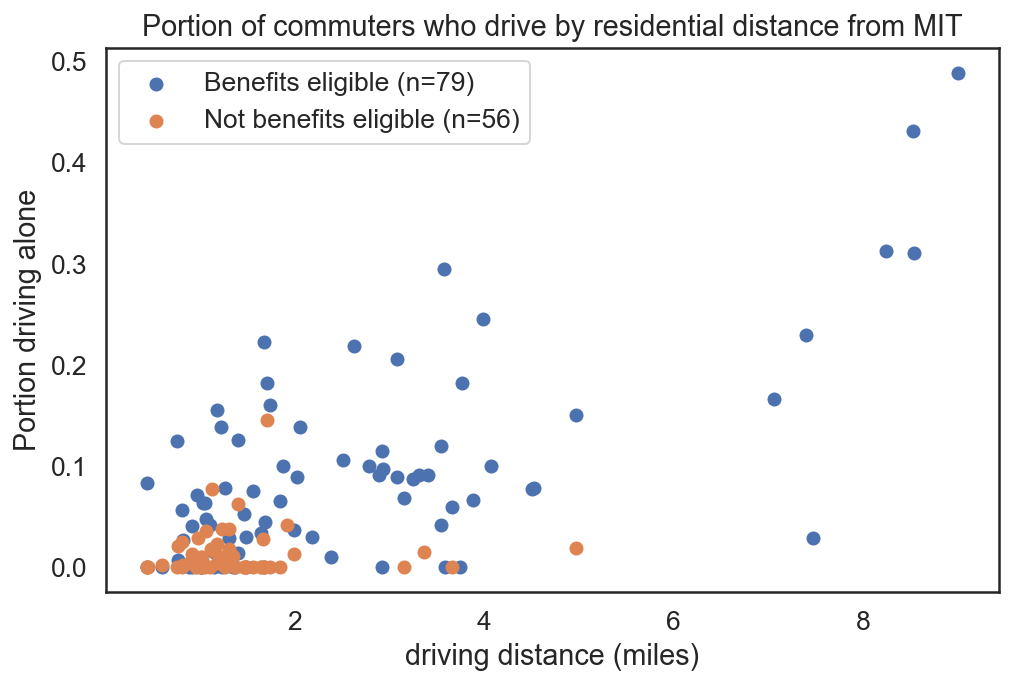

Benefits eligible correlation coefficient r = 0.687; p = 0.0
Non benefits eligible correlation coefficient r = 0.064; p = 0.64


----------------
 public transit time (minutes)


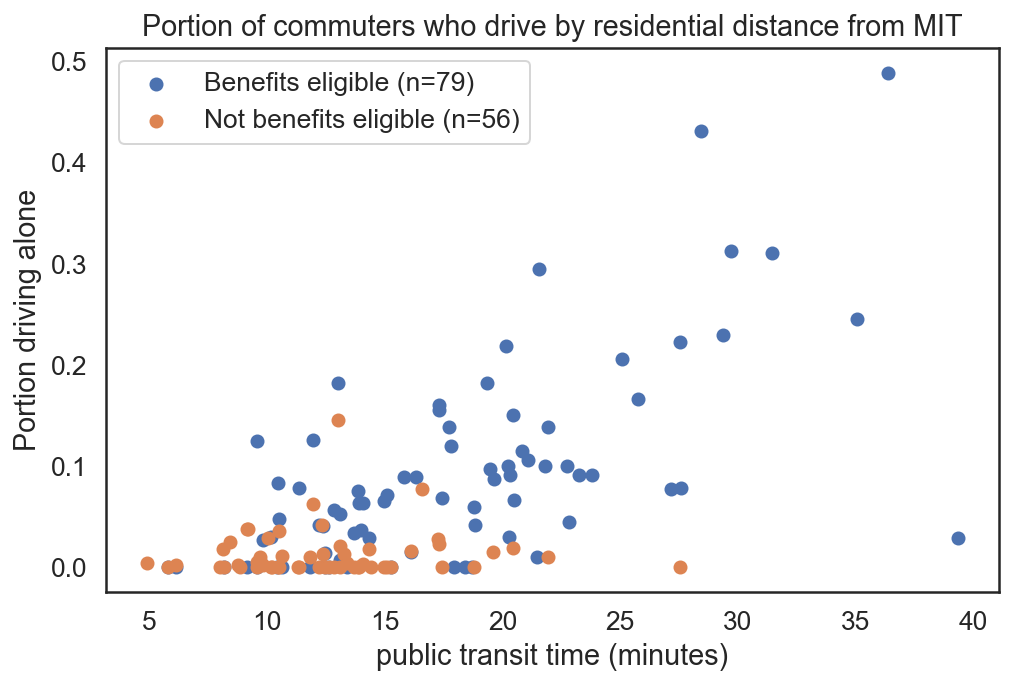

Benefits eligible correlation coefficient r = 0.655; p = 0.0
Non benefits eligible correlation coefficient r = 0.049; p = 0.718


,BenefitsEligible,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,,
250173531021,No,771,3.761905,0.499173,0.923854,9.579971,"POLYGON ((-71.10971 42.35307, -71.10923 42.353...",0.004879
250173531023,No,590,2.285714,0.304077,1.183525,4.878518,"POLYGON ((-71.09915 42.35594, -71.09802 42.356...",0.003874


In [393]:
ben_elgbl_agg_df = get_geoid_agg_df(completions_df, [BENEFITS_ELIGIBLE])
ben_elgbl_agg_df10 = ben_elgbl_agg_df[ben_elgbl_agg_df[N]>=10]

b_yes = ben_elgbl_agg_df10[
    ben_elgbl_agg_df10[BENEFITS_ELIGIBLE]=='Yes'
]
b_no = ben_elgbl_agg_df10[
    ben_elgbl_agg_df10[BENEFITS_ELIGIBLE]=='No'
]

for dist_m in distance_metrics:
    print('\n\n----------------\n', dist_m)
    x_yes, Y_yes = b_yes[dist_m], b_yes[DRIVE_ALONE_NORMALIZED]
    x_no, Y_no  = b_no[dist_m], b_no[DRIVE_ALONE_NORMALIZED]
    fig, ax = plt.subplots(1, figsize=(8,5))
    ax.scatter(x_yes, Y_yes, label='Benefits eligible (n=%s)'%len(x_yes))
    ax.scatter(x_no, Y_no, label='Not benefits eligible (n=%s)'%len(x_no))
    t = 'Portion of commuters who drive by residential distance from MIT'
    ax.set_title(t)
    ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
    ax.set_xlabel(dist_m)
    ax.legend()
    plt.show()
    stat, p = pearsonr(x_yes, Y_yes)
    print('Benefits eligible correlation coefficient r = %s; p = %s'%\
          (round(stat, 3), round(p, 3)))
    stat, p = pearsonr(x_no, Y_no)
    print('Non benefits eligible correlation coefficient r = %s; p = %s'%\
          (round(stat, 3), round(p, 3)))

ben_elgbl_agg_df.head(2)

In [417]:
types_agg_df = get_geoid_agg_df(completions_df, [TYPE_NUM])
types_agg_df10 = types_agg_df[types_agg_df[N]>=10]
types_agg_df10.head(3)

,TYPE_NUM,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,,
250173531023,Undergraduate Student,572,2.285714,0.304077,1.183525,4.878518,"POLYGON ((-71.09915 42.35594, -71.09802 42.356...",0.003996
250173531021,Undergraduate Student,570,3.000000,0.499173,0.923854,9.579971,"POLYGON ((-71.10971 42.35307, -71.10923 42.353...",0.005263
250173532001,Graduate Student,524,0.885714,0.602097,0.825491,9.831157,"POLYGON ((-71.10721 42.36048, -71.10709 42.360...",0.001690




----------------
distance to MIT (miles)

skipping Service Staff
skipping Faculty
skipping Sponsored Research Staff
skipping Support Staff
Other Academic Group correlation coefficient r = 0.278; p = 0.436
Undergraduate Student correlation coefficient r = 0.066; p = 0.837
skipping Administrative Staff
Graduate Student correlation coefficient r = 0.162; p = 0.288


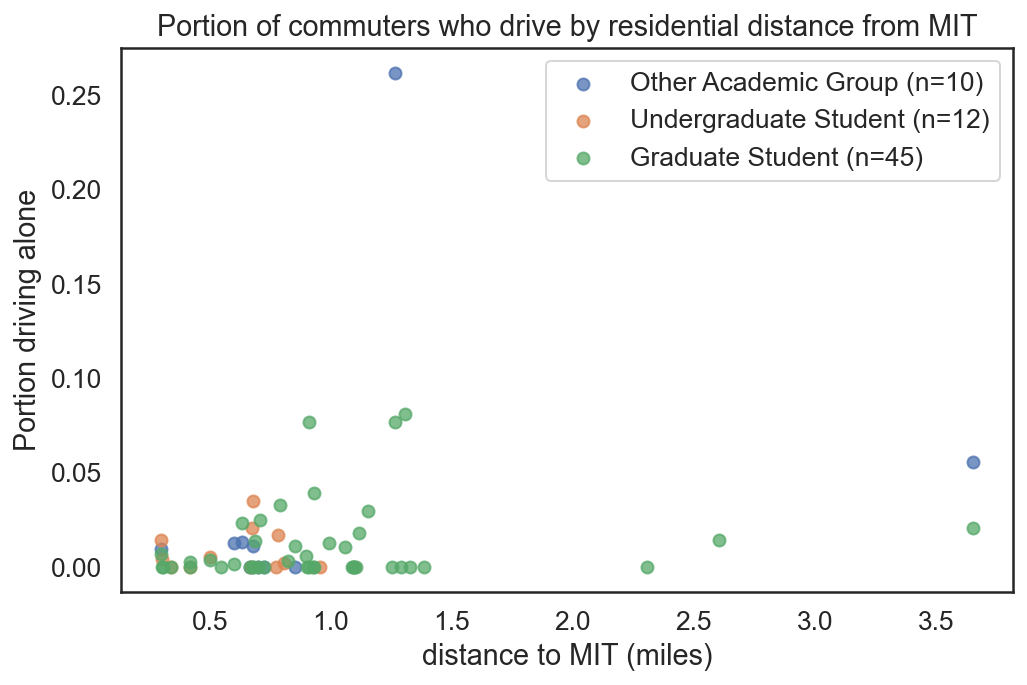



----------------
driving distance (miles)

skipping Service Staff
skipping Faculty
skipping Sponsored Research Staff
skipping Support Staff
Other Academic Group correlation coefficient r = 0.198; p = 0.583
Undergraduate Student correlation coefficient r = 0.249; p = 0.434
skipping Administrative Staff
Graduate Student correlation coefficient r = 0.109; p = 0.478


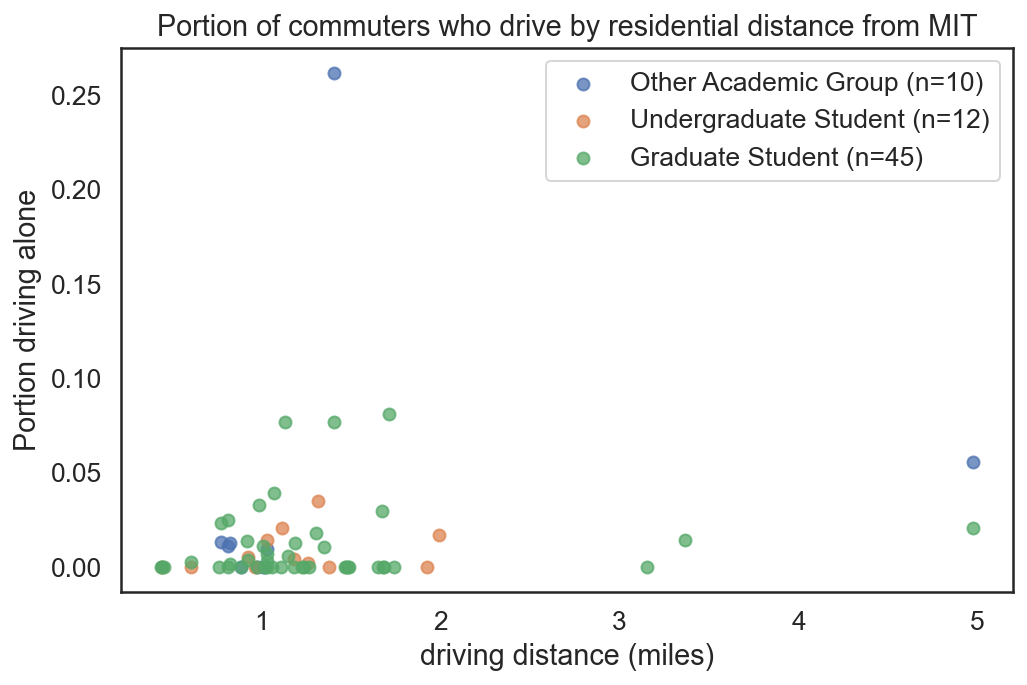



----------------
public transit time (minutes)

skipping Service Staff
skipping Faculty
skipping Sponsored Research Staff
skipping Support Staff
Other Academic Group correlation coefficient r = 0.018; p = 0.96
Undergraduate Student correlation coefficient r = 0.294; p = 0.354
skipping Administrative Staff
Graduate Student correlation coefficient r = 0.09; p = 0.558


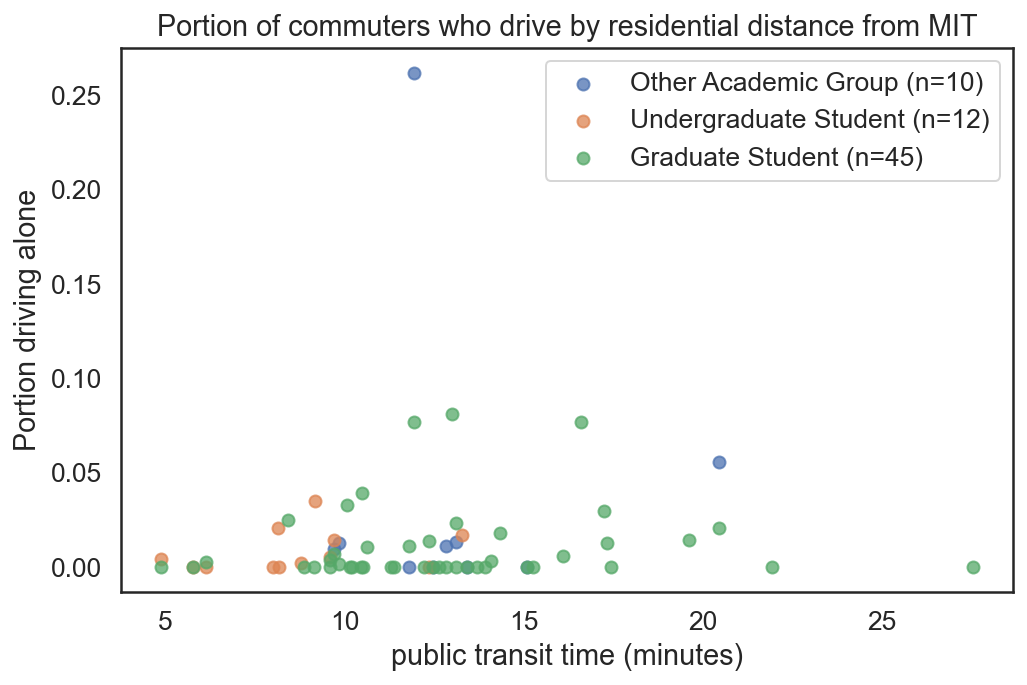

,BenefitsEligible,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,,
250173531021,No,771,3.761905,0.499173,0.923854,9.579971,"POLYGON ((-71.10971 42.35307, -71.10923 42.353...",0.004879
250173531023,No,590,2.285714,0.304077,1.183525,4.878518,"POLYGON ((-71.09915 42.35594, -71.09802 42.356...",0.003874


In [418]:
for dist_m in distance_metrics:
    print('\n\n----------------\n%s\n'%dist_m)
    fig, ax = plt.subplots(1, figsize=(8,5))
    for t in types:
        t_df = types_agg_df10[types_agg_df10[TYPE_NUM]==t]
        if len(t_df) < 2:
            print('skipping %s' % t)
            continue
        x, Y = t_df[dist_m], t_df[DRIVE_ALONE_NORMALIZED]
        ax.scatter(x, Y, alpha=0.75, label='%s (n=%s)'%(t, len(t_df)))
        stat, p = pearsonr(x, Y)
        print('%s correlation coefficient r = %s; p = %s'% \
              (t, round(stat, 3), round(p, 3)))
        
    title = 'Portion of commuters who drive by residential distance from MIT'
    ax.set_title(title)
    ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
    ax.set_xlabel(dist_m)
    ax.legend()
    plt.show()


ben_elgbl_agg_df.head(2)

# Linear Regression Model

We test the following models:

Model 1:

Yi = constant + β x distancei


Model 2:

Yi = constant + β x (PT commute time)i


Where 

- $Y_i$ = The proportion of people in a census block i who primarily commute by driving alone

- $distance_i$  = Geographic distance from the centroid of census block i to MIT
- $(PT commute\ time)_i$ = Commute time via public transit from the centroid of census block i to MIT

- Null hypothesis: β = 0
- Alternative hypothesis: β≠ 0

If the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant linear relationship between distance and the dependent variable.

We use data from all responses together in order to enable a larger  sample size, rather than differentiating by group.

Data is restricted to block groups with at least 10 survey respondents.

In [420]:
print('N = %s total block groups and %s total respondents' \
      % (len(all_agg_df10), all_agg_df10[N].sum()))

N = 138 total block groups and 5563 total respondents


In [421]:
Y = all_agg_df10[DRIVE_ALONE_NORMALIZED]

## Model 1

In [422]:
x1 = all_agg_df10[DISTANCE_TO_MIT]
# Pearson's Correlation Coefficient
stat, p = pearsonr(Y, x1)
print('The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))

The Pearson r correlation coefficient is 0.767, with a p-value of 0.000


In [423]:
model1_results = sm.OLS(Y, sm.add_constant(x1)).fit()
model1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Portion driving alone   R-squared:                       0.589
Model:                               OLS   Adj. R-squared:                  0.586
Method:                    Least Squares   F-statistic:                     194.9
Date:                   Wed, 27 Jan 2021   Prob (F-statistic):           4.93e-28
Time:                           21:27:00   Log-Likelihood:                 162.23
No. Observations:                    138   AIC:                            -320.5
Df Residuals:                        136   BIC:                            -314.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0252      0.010     -2.572      0.011      -0.045      -0.006
distance to MIT (miles)     0.0488      0.003     13.959      0.000       0.042       0.056
==============================================================================
Omnibus:                       33.103   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.376
Skew:                           0.669   Prob(JB):                     5.50e-36
Kurtosis:                       8.143   Cond. No.                         4.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a statitically significant linear relationship between commute distance to MIT and Portion of commuters who primarily drive alone, t = 13.959, p < 0.05.

adjusted $R^2 = 0.586$

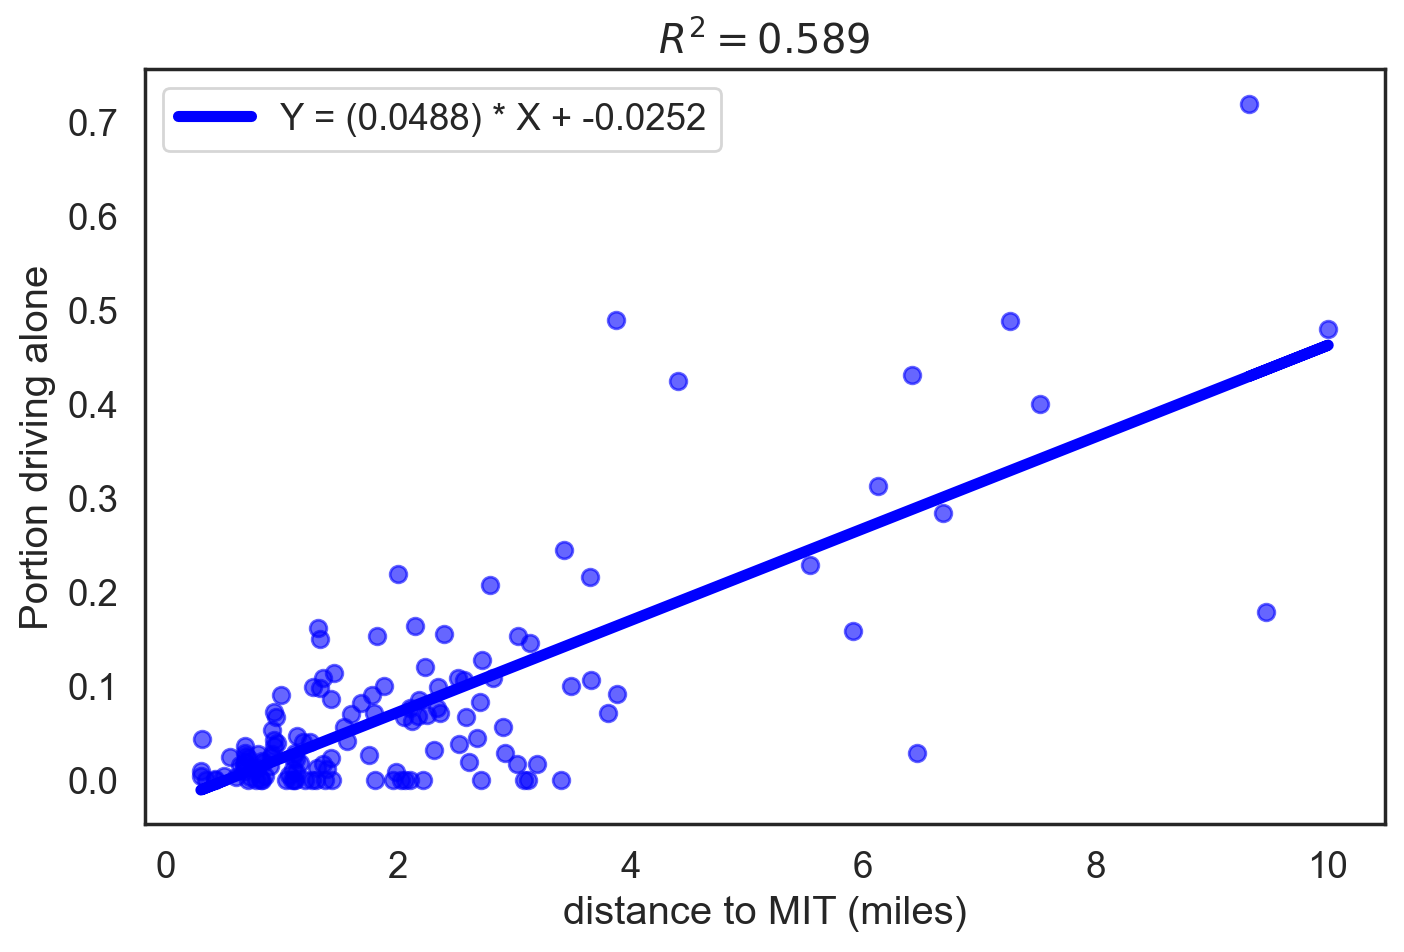

In [424]:
fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)
ax.scatter(x1,Y, c='blue', alpha=0.6)
yhat = (0.0488)*x1 + -0.0252 # The line of best fit
ax.plot(x1, yhat, lw=4, 
               c='blue', 
               label='Y = (0.0488) * X + -0.0252')
ax.set_xlabel(DISTANCE_TO_MIT)
ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
ax.set_title('$R^2 = 0.589$')
ax.legend()

Separate analysis for grad students vs staff.

In [352]:
graduate_agg_df = get_geoid_agg_df(completions_df[
    completions_df[TYPE_NUM]=='Graduate Student'
])
staff_agg_df = get_geoid_agg_df(completions_df[
    completions_df[TYPE_NUM].isin(
        ['Service Staff', 'Faculty', 'Sponsored Research Staff', 
         'Support Staff', 'Other Academic Group', 'Administrative Staff']
    )])
staff_agg_df.head(2)

,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,
250173530004,46,0.000000,0.850527,1.009417,11.798602,"POLYGON ((-71.10771 42.36785, -71.10743 42.368...",0.000000
250173532001,33,0.766667,0.602097,0.825491,9.831157,"POLYGON ((-71.10721 42.36048, -71.10709 42.360...",0.023232


In [377]:
# restrict data to GEOIDs with N >= 10
staff_agg_df10 = staff_agg_df[staff_agg_df[N]>=10]
graduate_agg_df10 = graduate_agg_df[graduate_agg_df[N]>=10]

print('Staff: N = %s total block groups and %s total respondents' \
      % (len(staff_agg_df10), staff_agg_df10[N].sum()))
print('Gradudate students: N = %s total block groups and %s total respondents' \
      % (len(graduate_agg_df10), graduate_agg_df10[N].sum()))

Staff: N = 85 total block groups and 1321 total respondents
Gradudate students: N = 45 total block groups and 1878 total respondents


In [378]:
staff_Y = staff_agg_df10[DRIVE_ALONE_NORMALIZED]
graduate_Y = graduate_agg_df10[DRIVE_ALONE_NORMALIZED]

In [379]:
staff_x1 = staff_agg_df10[DISTANCE_TO_MIT]
graduate_x1 = graduate_agg_df10[DISTANCE_TO_MIT]
# Pearson's Correlation Coefficient
stat, p = pearsonr(staff_Y, staff_x1)
print('For Staff data: The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))
stat, p = pearsonr(graduate_Y, graduate_x1)
print('For graduate data: The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))

For Staff data: The Pearson r correlation coefficient is 0.693, with a p-value of 0.000
For graduate data: The Pearson r correlation coefficient is 0.162, with a p-value of 0.288


In [380]:
staff_model1_results = sm.OLS(staff_Y, sm.add_constant(staff_x1)).fit()
staff_model1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Portion driving alone   R-squared:                       0.480
Model:                               OLS   Adj. R-squared:                  0.474
Method:                    Least Squares   F-statistic:                     76.71
Date:                   Wed, 27 Jan 2021   Prob (F-statistic):           1.99e-13
Time:                           19:42:24   Log-Likelihood:                 95.085
No. Observations:                     85   AIC:                            -186.2
Df Residuals:                         83   BIC:                            -181.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0046      0.014      0.333      0.740      -0.023       0.032
distance to MIT (miles)     0.0447      0.005      8.759      0.000       0.035       0.055
==============================================================================
Omnibus:                       17.196   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.011
Skew:                           0.648   Prob(JB):                     3.38e-09
Kurtosis:                       6.055   Cond. No.                         4.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [381]:
graduate_model1_results = sm.OLS(graduate_Y, sm.add_constant(graduate_x1)).fit()
graduate_model1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Portion driving alone   R-squared:                       0.026
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     1.156
Date:                   Wed, 27 Jan 2021   Prob (F-statistic):              0.288
Time:                           19:42:54   Log-Likelihood:                 111.66
No. Observations:                     45   AIC:                            -219.3
Df Residuals:                         43   BIC:                            -215.7
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0059      0.006      0.986      0.329      -0.006       0.018
distance to MIT (miles)     0.0055      0.005      1.075      0.288      -0.005       0.016
==============================================================================
Omnibus:                       36.524   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.976
Skew:                           2.339   Prob(JB):                     5.82e-19
Kurtosis:                       7.787   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

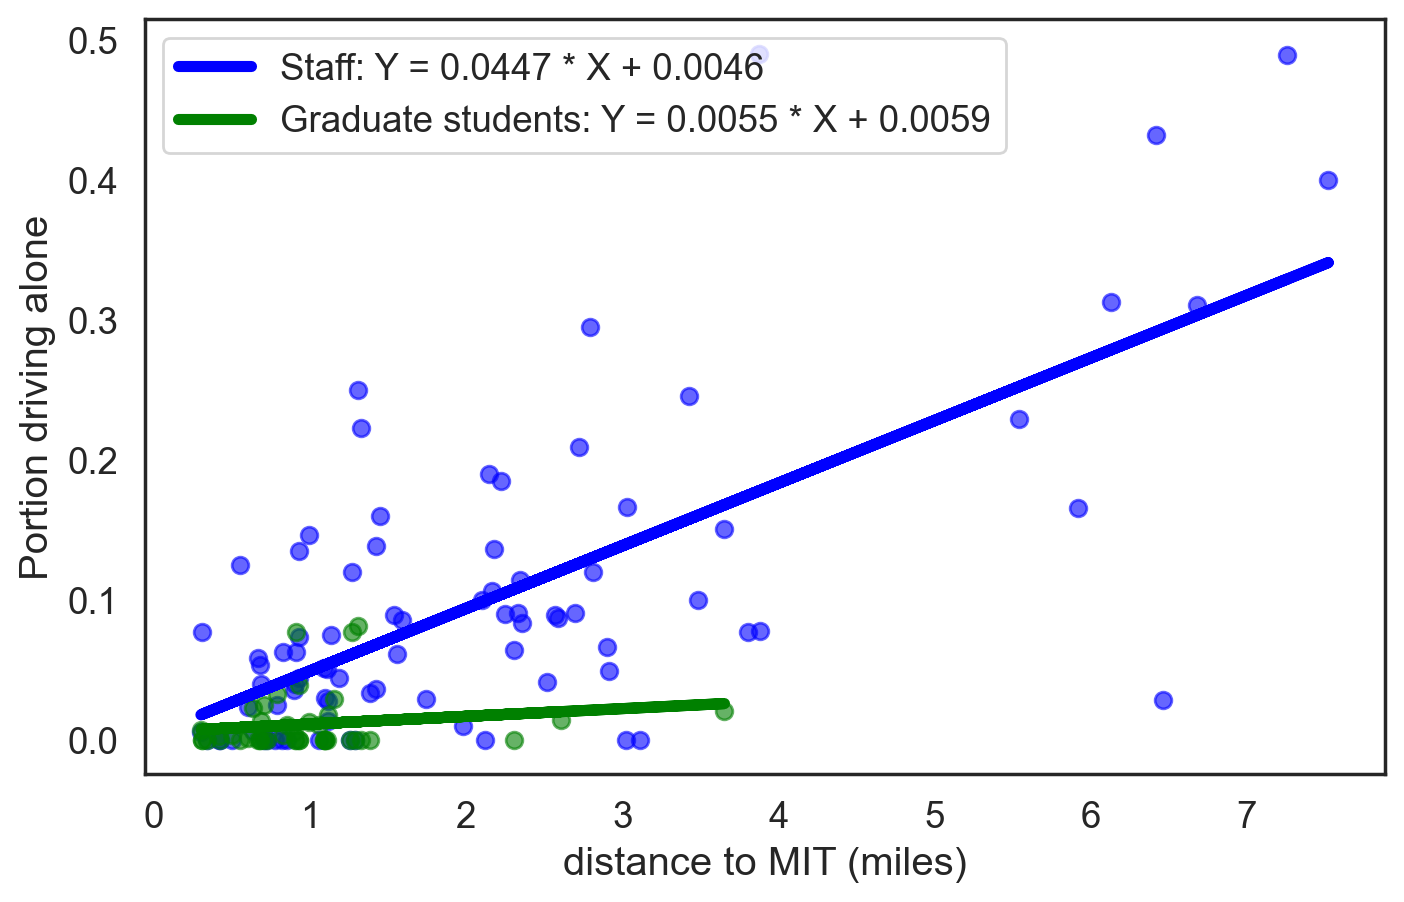

In [425]:
fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)
ax.scatter(staff_x1, staff_Y, c='blue', alpha=0.6)
staff_yhat = (0.0447)*staff_x1 + 0.0046 # The line of best fit
ax.plot(staff_x1, staff_yhat, lw=4, 
               c='blue', 
               label='Staff: Y = 0.0447 * X + 0.0046')

ax.scatter(graduate_x1, graduate_Y, c='green', alpha=0.6)
graduate_yhat = (0.0055)*graduate_x1 + 0.0059 # The line of best fit
ax.plot(graduate_x1, graduate_yhat, lw=4, 
               c='green', 
               label='Graduate students: Y = 0.0055 * X + 0.0059')

ax.set_xlabel(DISTANCE_TO_MIT)
ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
ax.legend()

## Model 2

In [308]:
x2 = all_agg_df10[PUBLIC_TRANSIT_TIME]
# Pearson's Correlation Coefficient
stat, p = pearsonr(Y, x2)
print('The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))

The Pearson r correlation coefficient is 0.742, with a p-value of 0.000


In [309]:
model2_results = sm.OLS(Y, sm.add_constant(x2)).fit()
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Portion driving alone   R-squared:                       0.551
Model:                               OLS   Adj. R-squared:                  0.547
Method:                    Least Squares   F-statistic:                     166.6
Date:                   Wed, 27 Jan 2021   Prob (F-statistic):           2.21e-25
Time:                           10:25:48   Log-Likelihood:                 156.06
No. Observations:                    138   AIC:                            -308.1
Df Residuals:                        136   BIC:                            -302.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.1030      0.016     -6.613      0.000      -0.134      -0.072
public transit time (minutes)     0.0099      0.001     12.906      0.000       0.008       0.011
==============================================================================
Omnibus:                       51.523   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.654
Skew:                           1.206   Prob(JB):                     8.31e-56
Kurtosis:                       9.189   Cond. No.                         47.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a significant linear relationship between commute time via public transit to MIT and Portion of commuters who primarily drive alone, t = 12.906, p < 0.05.

adjusted $R^2 = 0.547$

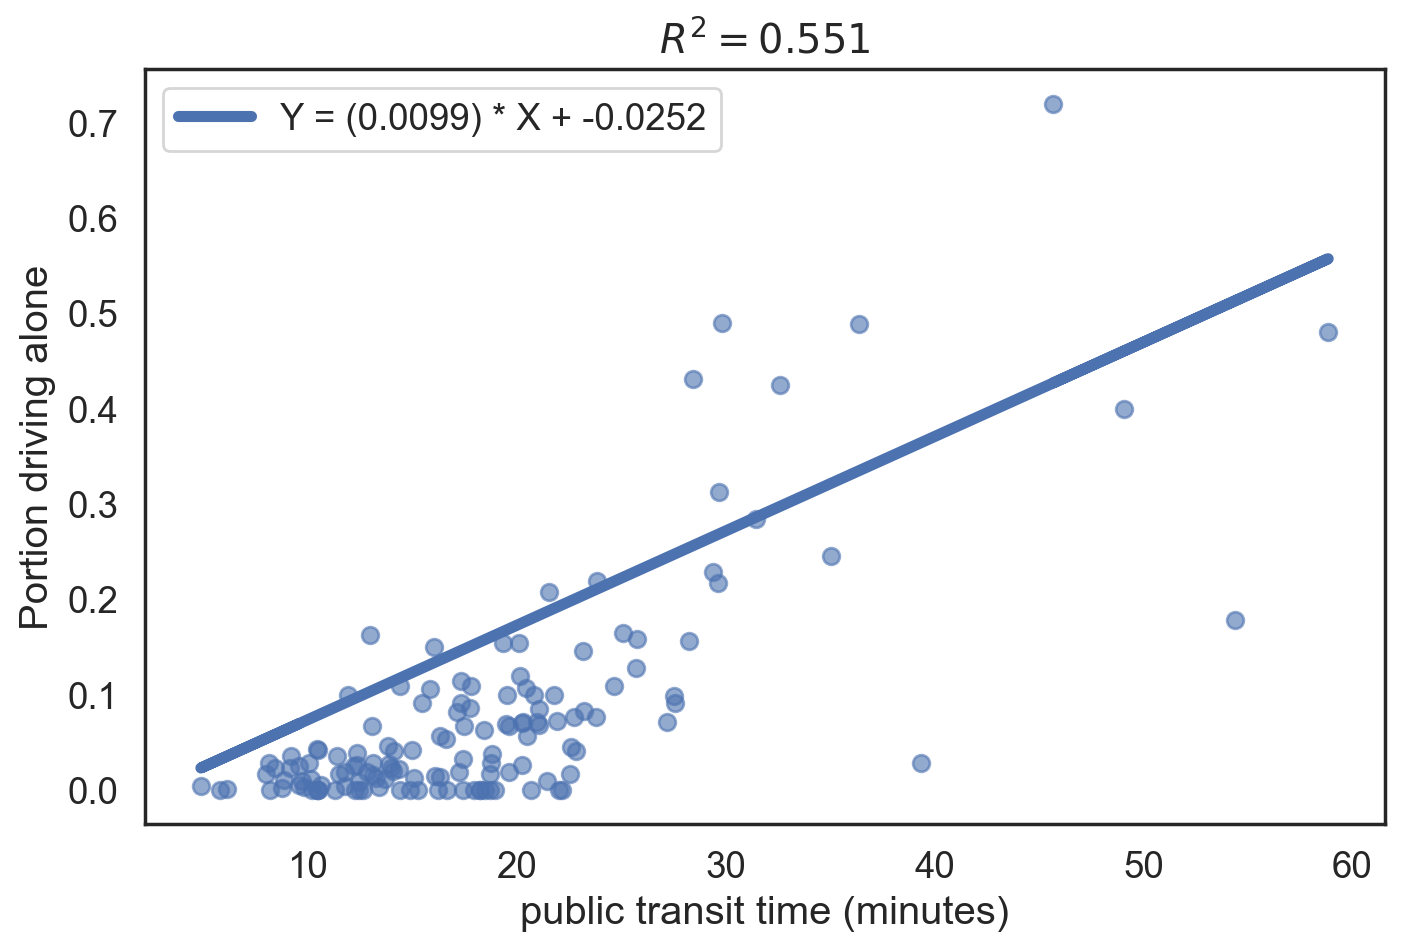

In [389]:
fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)
ax.scatter(x2,Y, alpha=0.6)
yhat = (0.0099)*x2 + -0.0252 # The line of best fit
ax.plot(x2, yhat, lw=4, 
               label='Y = (0.0099) * X + -0.0252')
ax.set_xlabel(PUBLIC_TRANSIT_TIME)
ax.set_ylabel(DRIVE_ALONE_NORMALIZED)
ax.set_title('$R^2 = 0.551$')
ax.legend()

In [390]:
all_agg_df10.head()

,N,drive alone (weighted by days per week),distance to MIT (miles),driving distance (miles),public transit time (minutes),geometry,Portion driving alone
GEOID,,,,,,,
250173531021,788,3.761905,0.499173,0.923854,9.579971,"POLYGON ((-71.10971 42.35307, -71.10923 42.353...",0.004774
250173531023,594,2.285714,0.304077,1.183525,4.878518,"POLYGON ((-71.09915 42.35594, -71.09802 42.356...",0.003848
250173532001,564,1.652381,0.602097,0.825491,9.831157,"POLYGON ((-71.10721 42.36048, -71.10709 42.360...",0.002930
250173531022,305,2.976190,0.299545,1.028866,9.708740,"POLYGON ((-71.09541 42.36050, -71.09456 42.360...",0.009758
250173531011,128,0.200000,0.417384,0.603724,6.127410,"POLYGON ((-71.10399 42.36342, -71.10373 42.363...",0.001563
